<a href="https://colab.research.google.com/github/abs711/makemore/blob/master/Makemore_optimizingMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/build_makemore/'

import os

os.listdir('./drive/MyDrive/build_makemore')


words = open(path+'names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words)))) # Get all the characters
stoi = {s:i+1 for i,s in enumerate(chars)} #string to integer
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

n_chars = len(itos)


In [6]:
n_dim = 10 #embedding dimensions
block_size = 3 # context length i.e. num of character used to predict the next character
hu = 300 # num of hidden tanh layer units

def build_dataset(words,block_size):
  X, Y = [], []

  for w in words:#[:5]:
  #     print(w + '.')
      context = [0] * block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
  #         print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix]


  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, X.dtype, Y.shape, Y.dtype)

  return X, Y

random.seed(42)
random.shuffle(words)

ntr = int(0.8*len(words))
nval = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:ntr],block_size)
Xval, Yval = build_dataset(words[ntr:nval],block_size)
Xts, Yts = build_dataset(words[nval:],block_size)


torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [7]:
# g = torch.Generator().manual_seed(2147483647)
# C = torch.randn(n_chars,n_dim,generator=g) # randomized two dimensional embedding for 27 characters

In [8]:
## C[5] or equivalently F.one_hot(torch.tensor(5), num_classes=27).float() @ C
## C[[5,6,7]] = C[torch.tensor([5,6,7])] #torch.tensor vs torch.Tensor
## C[X].shape = torch.Size([32, 3, 2])
## X[13,2] = 1 => C[X][13,2] = C[1]

# emb = C[Xtr]
# emb.shape

In [183]:
class MLP:
  def __init__(self, n_chars, n_dim,block_size,hu):
    g = torch.Generator().manual_seed(2147483647)
    self.C = torch.randn(n_chars,n_dim,generator=g)
    self.W1 = torch.randn((block_size*n_dim,hu),generator=g) * (5/3)/((block_size*n_dim)**0.5) # gain/fan_in
    self.b1 = torch.randn(hu,generator=g) * 0.01
    self.W1.shape, self.b1.shape

    self.W2 = torch.randn((hu,n_chars),generator=g) * 0.01
    self.b2 = torch.randn(n_chars,generator=g) * 0
    self.W2.shape, self.b2.shape

    self.bngain = torch.ones((1,hu)) #batchnorm_gain
    self.bnbias = torch.ones((1,hu)) #batchnorm_bias

    self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2, self.bngain, self.bnbias]

    self.bnmean_running = torch.zeros((1,hu))
    self.bnstd_running = torch.ones((1,hu))

    self.bnmean = None
    self.bnstd = None

    print("number of parameters", sum(p.nelement() for p in self.parameters))


    for p in self.parameters:
        p.requires_grad = True

    self.inside_info = None # storing activations
    # return g, C, W1, b1, W2, b2, bngain, bnbias, parameters

  def zero_grad(self):
    for p in self.parameters:
      p.grad = None

  def update_params(self, lr):
    for p in self.parameters:
      p.data += -lr*p.grad


  def forward_pass(self,X, mode, epc):

    emb = self.C[X] #[32, 3, 2]

    embcat = emb.view(-1,block_size*n_dim) #== torch.cat(torch.unbind(emb,1),dim=1) == torch.cat([emb[:,i,:] for i in range(block_size)],dim=1)

    hpreact = embcat @ self.W1 + self.b1
    if mode == 'train':
      bnmeani = hpreact.mean(0,keepdim=True)
      bnstdi = hpreact.std(0,keepdim=True)
      #batchnorm_layer
      hpreact = self.bngain*(hpreact-bnmeani)/bnstdi + self.bnbias
      with torch.no_grad():
        self.bnmean_running = 0.999 * self.bnmean_running + 0.001 *bnmeani
        self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * bnstdi

      h = torch.tanh(hpreact) # see below or refer to broadcasting rules
      # h.shape
      # 32, 100
      # 1,  100
      logits = h @ self.W2 + self.b2



    else:

      if self.bnmean == None or self.bnstd == None:
        print('Set batch norm mean and std')
      else:
        hpreact = self.bngain*(hpreact-self.bnmean)/self.bnstd + self.bnbias
        h = torch.tanh(hpreact) # see below or refer to broadcasting rules
      # h.shape
      # 32, 100
      # 1,  100
        logits = h @ self.W2 + self.b2

    self.inside_info = {'emb':emb, 'hpreact': hpreact, 'h': h}

    return logits, self.inside_info


In [184]:
# lre = torch.linspace(-3,0,1000)
# lrs = 10**lre

# lri = []
# lossi = []
# loss_val = []

In [185]:
lossi = []
loss_val = []
model = MLP(n_chars, n_dim,block_size,hu)
max_steps = 2000
batch_size = 32

for epc in range(max_steps):

    ix  = torch.randint(0,Xtr.shape[0], (batch_size,)) # minibatch
    logits, _ = model.forward_pass(Xtr[ix], 'train', epc)
    loss = F.cross_entropy(logits, Ytr[ix]) # Efficient Forward and Backward pass; Also, prevent overflow due to exponentiation of large logits

    model.zero_grad()

    loss.backward()

    lr = 0.1 if epc < 1000 else 0.01 ##lrs[epc]

    model.update_params(lr)

    # logits_val, _ = model.forward_pass(Xval, 'eval', epc)
    # loss_dev = F.cross_entropy(logits_val, Yval)
    if epc%100==0:
      print('epc:', epc, 'loss:', loss.item(), 'val_loss:', 'Update bnmean and bnstd')
      # print('epc:', epc, 'loss.log10:', loss.log10().item(), 'val_loss.log10:', loss_dev.log10().item())

    # lri.append(lr)
    lossi.append(loss.log10().item())
    # loss_val.append(loss_dev.log10().item())
    # break

number of parameters 18297
epc: 0 loss: 3.319127082824707 val_loss: Update bnmean and bnstd
epc: 100 loss: 2.677722692489624 val_loss: Update bnmean and bnstd
epc: 200 loss: 2.3679914474487305 val_loss: Update bnmean and bnstd
epc: 300 loss: 2.687934160232544 val_loss: Update bnmean and bnstd
epc: 400 loss: 2.2534685134887695 val_loss: Update bnmean and bnstd
epc: 500 loss: 2.680274724960327 val_loss: Update bnmean and bnstd
epc: 600 loss: 2.8421382904052734 val_loss: Update bnmean and bnstd
epc: 700 loss: 2.553013324737549 val_loss: Update bnmean and bnstd
epc: 800 loss: 2.9693844318389893 val_loss: Update bnmean and bnstd
epc: 900 loss: 2.4850149154663086 val_loss: Update bnmean and bnstd
epc: 1000 loss: 2.6958820819854736 val_loss: Update bnmean and bnstd
epc: 1100 loss: 1.964436650276184 val_loss: Update bnmean and bnstd
epc: 1200 loss: 2.2661490440368652 val_loss: Update bnmean and bnstd
epc: 1300 loss: 2.294889450073242 val_loss: Update bnmean and bnstd
epc: 1400 loss: 2.28355526

loss_train:  2.791004190229097


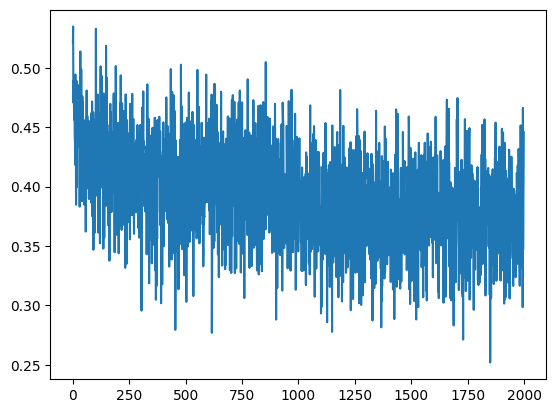

In [186]:
plt.plot(lossi)
# plt.plot(loss_val)
print("loss_train: ",10**lossi[-1])
# print("loss_train: ",lossi[-1],"loss_val:", loss_val[-1])

In [187]:
# calibrate the batchnorm statistics
with torch.no_grad():
  # pass the training set through
  emb = model.C[Xtr] #[32, 3, 2]
  embcat = emb.view(-1,block_size*n_dim)
  hpreact = embcat @ model.W1 + model.b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [194]:
@torch.no_grad()
def split_loss(split):
  x, y ={'train': (Xtr, Ytr),
         'val': (Xval, Yval),
         'test': (Xts, Yts)
         }[split]
  emb = model.C[x] #[32, 3, 2]
  embcat = emb.view(-1,block_size*n_dim)
  hpreact = embcat @ model.W1 + model.b1

  #batchnorm_layer
  hpreact = model.bngain*(hpreact-model.bnmean_running) / model.bnstd_running + model.bnbias

  h = torch.tanh(hpreact)
  logits = h @ model.W2 + model.b2
  loss = F.cross_entropy(logits, y)
  print(split, 'loss:', loss.item())

split_loss('train')
split_loss('val')

train loss: 2.350267171859741
val loss: 2.349581718444824


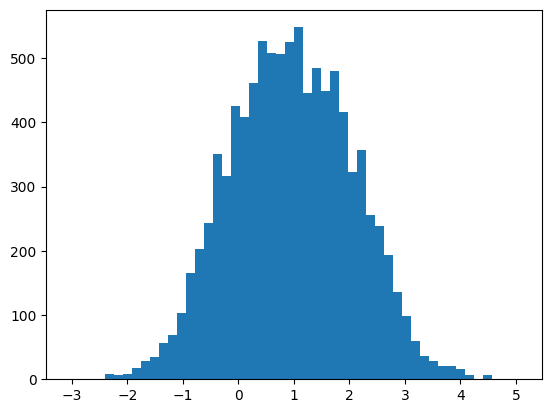

In [195]:
# diagnostics
@torch.no_grad()
def diagnostic_run():
  model.bnmean, model.bnstd = model.bnmean_running, model.bnstd_running
  logits, inside_info = model.forward_pass(Xtr[ix],'eval',0)
  VOI = inside_info['hpreact']
  plt.hist(VOI.view(-1).tolist(),50)
  return VOI
voi = diagnostic_run()

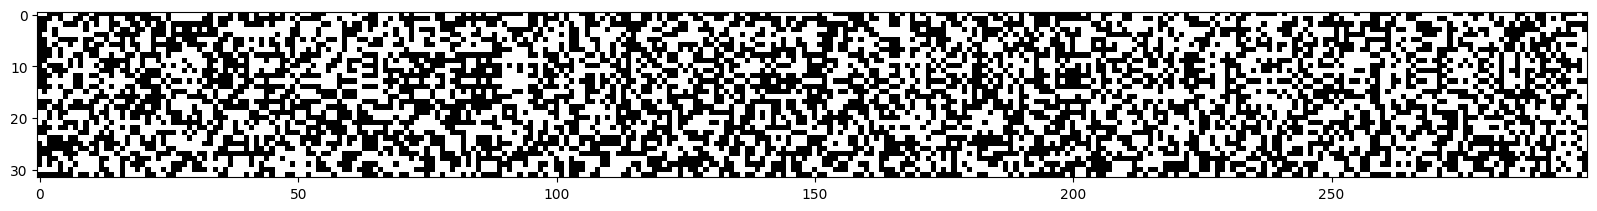

In [197]:
plt.figure(figsize=(20,10))
plt.imshow(voi.abs() > 0.99, cmap='gray',interpolation='nearest')